# 2. Užduotis

In [1]:
utils <- source("../src/utils.R")$value

library(latex2exp)

Naudodami atvirkštinės transformacijos metodą, sumodeliuokite atsitiktinio dydžio $T$, turinčio Veibulo skirstinį su parametrais $\eta$ ir $\nu$, t.y. a. d. $T$ pasiskirstymo funkcija yra

$$
F(t; \eta, \nu) = 1 − \exp{\{-{(t/\eta)}^\nu\}},
$$

didumo $n = 100$ paprastąją atsitiktinę imtį. Atlikite užduotis:

In [24]:
n <- 100
eta <- 2 # laisvai pasirinkti 
nu <- 2

inverse_cdf <- function(theta) {
    function(probs) {
        theta[1] * (-1 * log(1 - probs)) ^ (1 / theta[2])
    }
}

observ <- inverse_cdf(c(eta, nu))(runif(n))

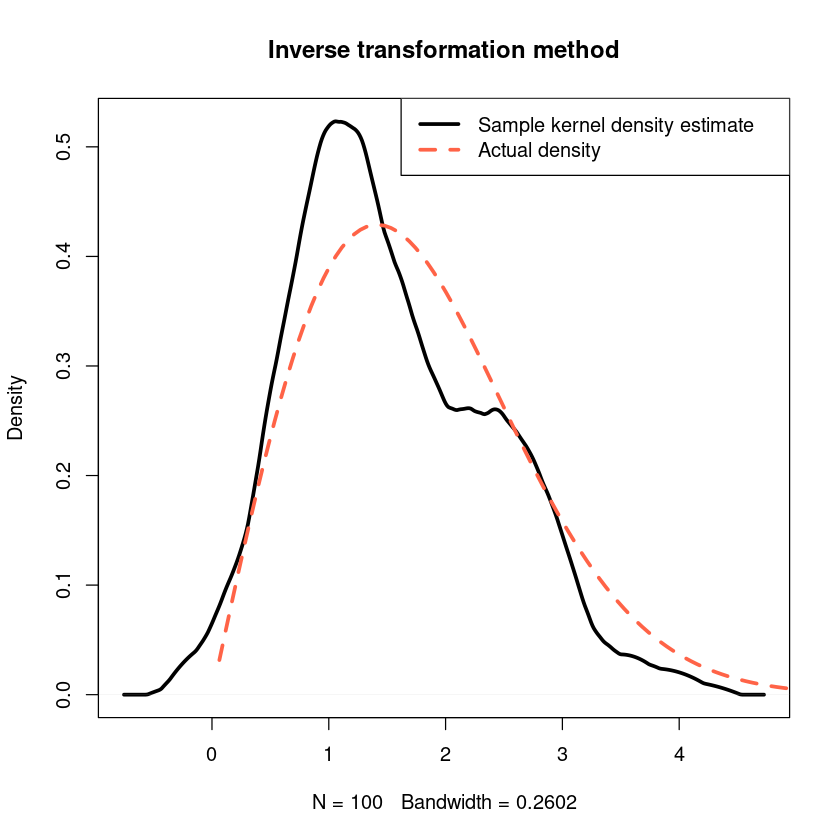

In [25]:
## Imties tankio įvertis
dens <- utils$kernel_density_estimate(observ)

## Teorinis tankis
lo <- qweibull(0.001, eta, nu)
hi <- qweibull(0.999, eta, nu)
x <- seq(lo, hi, length.out = 100)

plot(dens, main = "Inverse transformation method", col = "black", lwd = 3)
lines(x, dweibull(x, eta, nu), col = "tomato", lwd = 3, lty = 2)
legend(
    "topright",
    legend = c("Sample kernel density estimate", "Actual density"),
    col = c("black", "tomato"),
    lty = c(1, 2),
    lwd = c(3, 3)
)

a) Įrodykite, jeigu $X$ skirstinys yra Veibulo, t.y. $X \sim W(\eta, \nu)$;
$F(x; \eta, \nu) = 1 − \exp{\{-{(t/\eta)}^\nu\}}$, tai $Y = \ln{X}$ skirstinys yra $F(y) = 1 - 1 − \exp{\{ - e^{(y - \mu)/\sigma}\}}$, $\sigma = 1 / \nu$, $\mu = \ln{\eta}$.

b) Parinkite pradinį artinį. **Pastaba:** $X \sim W(\eta, \nu)$; $Y = \ln{X}$; $\mathbb{E}Y = \mu - \gamma \sigma$, $\gamma = 0.5772156$; $\mathbb{V}Y = {(\pi \sigma)}^2 / 6$

Naudokimės momentų metodu:

In [27]:
gamma <- 0.5772156

c) Naudodami `R` programos funkciją `maxLik`, `optim` arba kitą `R` optimizavimo funkciją
didžiausiojo tikėtinumo metodu įvertinkite parametrus $\eta$ ir $\nu$. Palyginkite su tikromis parametrų
reikšmėmis.

In [ ]:
loglik <- function(obserations) {
    function(theta) {
        
    }
}

d) Tarkime, kad modeliuoti duomenys žymi gaminio darbo laiką. Įvertinkite tikimybę,
kad gaminys dirbs ilgiau negu laiką t. Raskite laiko momentą iki kurio sugenda 30% gaminių.